# Read csv

In [1]:
import pandas as pd
import numpy as np
import sys
import os.path
import matplotlib.pyplot as plt

model = 'model'
tolerance = 'tolerance'
point_id = 'point_id'
time = 'time'
values = 'values'

headers = [model, tolerance, point_id, time, values]
types = {
    model : str,
    tolerance : np.float64,
    point_id: np.int64,
    time : np.int64,
    values: str,
}

df = pd.read_csv('simple_tolerance_tests.csv', header = 0, names = headers, low_memory = False, dtype = types)

In [2]:
p1 = 'p1'
p2 = 'p2'
p3 = 'p3'
p4 = 'p4'
p5 = 'p5'
p6 = 'p6'
p7 = 'p7'
p8 = 'p8'
p9 = 'p9'
avg = 'avg'

# Átlagos szórás az eredmények között
Adatfeldolgozás:
1. SPDN által visszaadott reward eredmények a _values_ oszlopban, ;-vel elválasztva
2. Ezeket külön oszlopokra bontjuk, a _pointid_ alapján eggyesítjük, oszlopok (vagyis reward eredmények) szórását vesszük
3. Külön _avg_ oszlopban átlagoljuk soronként a szórásokat
4. Az így kapott összes sorra átlagoljuk a szórás átlagokat :D

In [3]:
def getAvgVariances(newDf):
    # These must be done before getAvgVariances:
    #    smpl_df = df[df.model == 'SMPL']
    #    smpl_df[p1], smpl_df[p2] = df[values].str.split(';', 1).str
    for col in newDf.columns:
        newDf[col] = pd.to_numeric(newDf[col], errors = 'coerce')
    newDf = newDf.drop(columns=[model, tolerance, time, values])\
                    .groupby(point_id).var()\
                    .dropna(thresh=1)
    newDf[avg] = newDf[newDf.columns[0]]
    for col in newDf.columns[1:(len(newDf.columns)-1)]:
        newDf[avg] = newDf[avg] + newDf[col]
    newDf[avg] = newDf[avg] / (len(newDf.columns) - 1)
    return np.average(newDf.loc[:,avg].values)
    

In [4]:
avgs = {}

smpl_df = df[df.model == 'SMPL']
smpl_df[p1], smpl_df[p2] = df[values].str.split(';', 1).str
avgs['SMPL'] = getAvgVariances(smpl_df)

vcls_df = df[df.model == 'VCLS']
vcls_df[p1], vcls_df[p2], vcls_df[p3], vcls_df[p4],vcls_df[p5], vcls_df[p6],vcls_df[p7]  = df[values].str.split(';', 6).str
avgs['VCLS'] = getAvgVariances(vcls_df)

hybc_df = df[df.model == 'HYBC']
hybc_df[p1], hybc_df[p2], hybc_df[p3], hybc_df[p4]  = df[values].str.split(';', 3).str
avgs['HYBC'] = getAvgVariances(hybc_df)

fil3_df = df[df.model == 'FIL3']
fil3_df[p1], fil3_df[p2], fil3_df[p3] = df[values].str.split(';', 2).str
avgs['FIL3'] = getAvgVariances(fil3_df)

fil5_df = df[df.model == 'FIL5']
fil5_df[p1], fil5_df[p2], fil5_df[p3], fil5_df[p4], fil5_df[p5]   = df[values].str.split(';', 4).str
avgs['FIL5'] = getAvgVariances(fil5_df)

fil7_df = df[df.model == 'FIL7']
fil7_df[p1], fil7_df[p2], fil7_df[p3], fil7_df[p4], fil7_df[p5], fil7_df[p6], fil7_df[p7]   = df[values].str.split(';', 6).str
avgs['FIL7'] = getAvgVariances(fil7_df)

fil9_df = df[df.model == 'FIL9']
fil9_df[p1], fil9_df[p2], fil9_df[p3], fil9_df[p4], fil9_df[p5], fil9_df[p6], fil9_df[p7], fil9_df[p8], fil9_df[p9] = df[values].str.split(';', 8).str
avgs['FIL9'] = getAvgVariances(fil9_df)

avgs

C:\Users\Timi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Timi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Timi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

{'SMPL': 0.0,
 'VCLS': 824.9564314320025,
 'HYBC': 38.444645417998125,
 'FIL3': 0.0013312947054801337,
 'FIL5': 0.003193035294466044,
 'FIL7': 0.002300327314036227,
 'FIL9': 0.009702338289007474}

# Mean runtime with different tolerance

In [5]:
sum_times_df = df.loc[:,[model,tolerance,time]].groupby([model,tolerance]).mean().sort_values(by=[model, tolerance])

models = sum_times_df.index.levels[0].tolist()
tols = sum_times_df.index.levels[1].tolist()

sum_times_df = sum_times_df.reset_index()
for mod in models:
    tempDf = sum_times_df[sum_times_df.model == mod]
    for t in tols:
        tempDf_tol = tempDf[tempDf.tolerance == t]
        if len(tempDf_tol) == 0:
            sum_times_df.loc[-1] = [mod, t, 0]  # adding a row
            sum_times_df.index = sum_times_df.index + 1  # shifting index
            sum_times_df = sum_times_df.sort_values(by=[model,tolerance])  # sorting by index

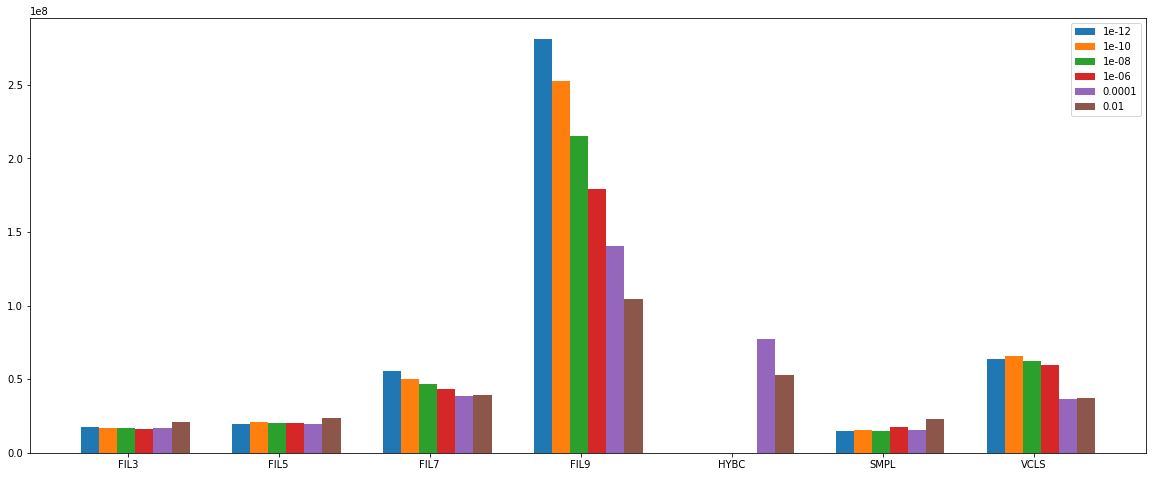

In [6]:
arrays=[]
for x in tols:
    arrays.append([])

tasks = sum_times_df.loc[:,time].reset_index()
tasks['index'] = np.arange(tasks.time.count())
for x in range(tasks.time.count()):
    nextTime = tasks.loc[tasks['index']==x].iloc[0].time
    arrays[x%len(tols)].append(nextTime)

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

ind = np.arange(7)  # the x locations for the groups
xIdx = -0.25
wi = 0.12
i = 0
for array in arrays:
    ax.bar(height=array, x=ind+xIdx, width=wi, label=tols[i])
    xIdx = xIdx + wi
    i = i+1
    
ax.set_xticks(ind)
ax.set_xticklabels(models)
plt.legend()
plt.show()